# Обучение агента на среде [ViZDoom](https://github.com/mwydmuch/ViZDoom)

## Сценарий - "защищай центр" (defend the center)

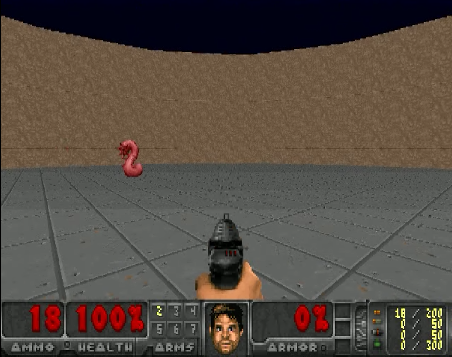

Для того, чтобы запустить среду ViZDoom в колаб-ноутбуке, нам нужно сначала установить различные дополнительные программы которые упомянаются в официальной документации.

In [ ]:
%%bash
#%%bash - значит используем командную строку (не код питона)
# Устанавливаем нужные программы, которая требует от нас документация: https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [62.2 kB]
Hit:12 http://ppa.launchpad.net/cran/

Затем, устанавливаем саму библиотеку ViZDoom из её гитхаб репозитории.

In [ ]:
#Обычно уходит 5-10 минут на установку этой библиотеки.
!pip install vizdoom

     |████████████████████████████████| 21.9MB 143kB/s 
  Created wheel for vizdoom: filename=vizdoom-1.1.8-cp37-none-any.whl size=14461418 sha256=d74bb23c73175dd2e1effd8dee6edf446f7185cb2fad3d36f5d63a3bb55a5e86
  Stored in directory: /root/.cache/pip/wheels/7d/04/dd/fafbaf68bb30e82ca4e336b9e13813d667d81aecb4648227a3
Successfully built vizdoom


Подключаемся к диску и импортируем все нужные модули и библиотеки.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from vizdoom import *         #Импортируем все функции из cреды ViZDoom
import tensorflow as tf       #Библиотека тензорфлоу
import numpy as np            #Библиотека numpy
import random                 #Импортируем модуль для генерации рандомных значений
import pickle                 #Модуль для сохранения результатов в файл
import cv2                    #Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
import matplotlib.pyplot as plt #Импортируем модуль pyplot из бибиотеки matplotlib

from tensorflow.keras.models import load_model, Model, Sequential #Импортируем функции для создания и загрузки модели из тензорфлоу
from tensorflow.keras.layers import *                             #Импортируем все слои из кераса
from tensorflow.keras.optimizers import RMSprop                   #Импортируем оптимизатор RMSprop
from tensorflow.keras import backend as K                         #Импортируем модуль для бэкэнда кераса
from tensorflow.keras.utils import to_categorical                 #Импортируем функцию для удобного onehot энкодинга
from moviepy.editor import *                                      #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
from google.colab import output                                   #Импортируем функцию для управления вывода в колаб-ячейках

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1990656/45929032 bytes (4.3%)5169152/45929032 bytes (11.3%)8314880/45929032 bytes (18.1%)11812864/45929032 bytes (25.7%)15294464/45929032 bytes (33.3%)18735104/45929032 bytes (40.8%)22110208/45929032 bytes (48.1%)25591808/45929032 bytes (55.7%)28868608/45929032 bytes (62.9%)31932416/45929032 bytes (69.5%)35045376/45929032 bytes (76.3%)38322176/45929032 bytes (83.4%)

## Сначала нужно создать много разных функций

Эти функции будут создавать нейронную сеть, извлекать данные, преобразовывать данные, обучать нейронную сеть, и тд. Cначала создаем функцию которая возвращает нужную нейронную сеть.

Здесь используется классическая DQN нейросеть, которая будет принимать небольшую последовательность кадров из игровой среды на вход. На выходе будет столько же нейронов, сколько возможных дискретных действий в среде. Каждый нейрон предсказывает значение ожидаемой награды (Q(s, a)) за соответствующее действие.

Ниже представленная функция будет использоваться для создания основной и целевой модели.

In [ ]:
# Функция для создания нейронной сети принимает на вход размер картинок, количество возможных действий, и шаг обучения.
def Make_DQN(input_shape, action_size, learning_rate):
  model = Sequential()                                                                       #Эту нейронную сеть можно создать через Sequential
  model.add(Conv2D(32, 8, strides = (4,4), activation = 'relu', input_shape=(input_shape)))  #Нейронная сеть будет принимать картинки на вход
  model.add(Conv2D(64, 4, strides = (2,2), activation = 'relu'))                             #по этому мы создаем свёрточные блоки
  model.add(Conv2D(64, 4, activation = 'relu'))
  model.add(Flatten())                                                            #Выравнивающий слой с пуллингом
  model.add(Dense(512, activation = 'relu'))                                                                            
  model.add(Dense(action_size, activation = 'linear')) #Выходной слой должен иметь активационную функцию 'linear' - мы предсказываем награды на выходе НС.

  optimizer = RMSprop(lr = learning_rate) #Практика показывает что RMSprop хороший оптимизатор для обучения с подкреплением, однако можно использовать adam.
  model.compile(loss = 'mse', optimizer = optimizer) #Компилируем модель с функции ошибки mse и заданным оптимизатором.

  return model     #Функция возвращает готовую, компилированную модель.

Для удобства, добавим короткую функцию для обновления весов в целевой модели (которая будет создаваться позже).

In [ ]:
def update_target_model(): #Функция ставит веса целевой модели (которая не обучается) как веса основной модели (которая обучается).
  target_model.set_weights(main_model.get_weights())

Ниже задаются различные гиперпараметры для обучения нашей DQN нейросети. Более важные гиперпараметры подробнее описываются ниже:

**gamma (гамма):** значение от 0 до 1 - чем больше значения этого параметра, тем больше нейронная сеть будет приотеризировать награды которая она может получить в будующем. 

**observation_steps (количество шагов наблюдения):** количество шагов, за который алгоритм не обучается но добавляет новую информацию (состояния, действия, награды) в память. Это необходимо, чтобы алгоритм не переобучался на маленьком объеме памяти.

**target_model_update_frequency (частота обновления целевой модели):** Определяет количество шагов, после которого мы обновляем целевую модель (копируем все веса основной модели в целевую модель). В оригинальной статье по Q-learning использовалось 10000 шагов, но в этом примере мы будем использовать 5000 шагов.

In [ ]:
gamma = 0.95                      #Гамма (параметр для передачи наград между состояний)
initial_epsilon = 1               #Начальное значение эпсилон (вероятность принять рандомный шаг)
epsilon = initial_epsilon         #Текущее значение эпсилон (инициализируется как стартовое значение)
final_epsilon = 0.01              #Минимальное значение эпсилон (должен быть выше 0)
epsilon_decay_steps = 200000      #Мы будем уменьшать значение эпсилона на протяжении 200,000 шагов

epsilon_decay_factor = (initial_epsilon - final_epsilon)/epsilon_decay_steps #Задаем количество на которое будем снижать эпсилон после каждого шага   

observation_steps = 10000            #Количество шагов в игровой среде до обучения сети 
timesteps_per_train = 100            #Обучаем модель раз в 100 шагов (не обязательно ждать до конца игры)
target_model_update_frequency = 5000 #Обновляем значения целевой модели раз в 5000 шагов

learning_rate = 1e-4   #Обычно в обучении с подкреплением ставят низкий шаг обучения, например 1e-4
batch_size = 32        #Используем размер пакета в 32

Нужно также добавить несколько дополнительных функций. Начнём с функцию предобработки картинок.

Картинки игровой среды будут довольно большими (на порядке 320 х 480 или 640 х 960) - нам такие большие не нужны. По этому, мы будем сжимать каждую картинку в меньший размер (64 х 64).

Также, по умолчанию картинки цветные, но для нашей сети достаточно иметь чёрно-белые картинки. Таким образом, картинки будум занимать меньше памяти и нейронная сеть будет обрабатывать их быстрее.

Конкретно в этой среде картинки также имеют другую размерность от того, что принято - а именно (3, width, height) вместо (width, height, 3). Нам нужно преобразовать массив чтобы устранить этот момент.

Мы создадим функцию для преобразования картинок выше-описанным образом.

In [ ]:
image_width = 64   #Ширина картинки (кадра)
image_height = 64  #Высота картинки (кадра)
num_frames = 4     #Количество последовательных кадров в одном состоянии (используется позже)
#Размерность каждого состояния будет размер картинки (её высота и ширина) на количество последовательных кадров
state_shape = (image_width, image_height, num_frames) 

def preprocess_frame(frame):
  frame = np.rollaxis(frame, 0, 3) #Сначала нужно предобрадотать картинку чтобы размер поменялся с (3, width, height) на (width, height, 3).
  frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_CUBIC) #Меняем размерность картинки на (64 х 64)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Делаем изображение чёрно-белым

  return frame.reshape(image_width, image_height, 1)/255 #Делаем решейп, и возврашаем предобработанную картинку, нормализуем

Также создаем функцию для предобработки наград. Награды могут назначаться автоматический, но также можно и крайней желательно регулировать вручную. Однозначный плюс среды ViZDoom - мы можем легко менять логику, с которой назначаются награды за различные события в среде (например: убил врага = 100 очков награды).

Наша функция будет принимать информацию из игры на текущее и предидущее состояние на вход, а также булевое значение - если кадр является последним в эпизоде. В соответствии с этой информацией мы можем задавать награду r(s, a), по которой наш алгоритм будет обучаться.

In [ ]:
#previous_misc - информация о игровой среде на предидущий кадр (количество убитых врагов, патроны, и здоровие)
#current_misc - информация о игровой среде на текущий кадр (количество убитых врагов, патроны, и здоровие)
#episode_done - булевое значение, которое говорит если кадр является последним в эпизоде.

#misc[0] - количесто убитых врагов, misc[1] - патроны, misc[2] - здоровие
#########################################!!!ВАЖНО!!!#########################################
#информация которая содержится в массивах previous_misc и current_misc а также индексы могут отличаться в зависимости от конкретного сценария из ViZDoom.
#Эту информацию можно посмотреть или поменять в соответствующих .cfg файлах, с помощью которого строится среда. 
#Данная функция заточена под сценарий который рассматривается на уроке - но ниже представленную функцию нужно поменять при использовании других сценарий.

def get_reward(previous_info, current_info, episode_done):
  reward = 0     #Инициализируем награду как 0
  if episode_done:                          #Если кадр является последним в игре, ставим награду как -0.1 и возвращаем её (агент умер)
    reward = -0.1
    return reward
  if current_info[0] > previous_info[0]:   #Если убили врага в кадре, увеличиваем награду на 1
    reward += 1
  if current_info[1] < previous_info[1]:   #Если потеряли здоровие, уменьшаем награду на 0.1
    reward -= 0.1
  if current_info[2] < previous_info[2]:   #Если использовали патрон, уменьшаем награду на 0.1
    reward -= 0.1

  return reward  #Возвращаем подсчитанную награду

Создадим функцию, по которой наш агент будет принимать действие. В этой функции. нейронная сеть будет предсказывать награду к которой нас приведёт каждое дискретное действие (Q(s', a)). Затем, в зависимости от текущего значения эпсилон (е), у нас будет вероятность 1-e принять действие которое должно привести к наибольшей награде и вероятность е принять рандомное действие (это нужно чтобы агент исследовал среду и позновал новую информацию).

Также, для удобвста мы зададим код для снижение значения эпсилон при каждом вызове этой функции.

In [ ]:
#Функция принимает текущее состояние, значение эпсилон, и количество возможных шагов на вход, 
#и возвращает действие который агент будет принимать и новое значение эпсилон.
def get_action(state, epsilon, action_size):

  if random.random() <= epsilon:  #Генерим рандомное значение, если оно меньше или равно эпсилону, берём рандомное действие
    action_index = np.random.randint(0, action_size) #Инными словами, мы берём рандомное действие с вероятностью эпсилон.
  else: #Иначе (наше рандомное число больше чем эпсилон)
    Q_values = main_model.predict(np.expand_dims(state, axis = 0)) #Предсказываем все Q-значения при следующим действии (Q(s, a) для каждого действия a)
    action_index = np.argmax(Q_values) #Извлекаем индекс действия который приводит к максимальному значению Q(s, a)

  if epsilon > final_epsilon:       #Снижаем значение эпсилон, если оно больше чем final_epsilon, снижаем значение epsilon на epsilon_decay_factor.
    epsilon -= epsilon_decay_factor

  return action_index, epsilon #Возвращаем выбранное действие и новое значение epsilon

Дальше создаем буфер памяти. В ходе обучения, мы будем сэмплить примеры из буфера рандомным образом чтобы избежать переобучение. 

Для создания буфера мы будем использовать специальный тип данных из встроенного модуля питона, который называется deque. Deque работает также как обычный питоновский список, но с одном важным отличием - у него есть максимальная длина (максимальное количество элементов, которое может храниться одновременно).

Когда эта максимальная длина привышается и в deque добавляется новый элемент, также будет удаляться самый старый элемент. В итоге, у нас будет буфер памяти который хранит данные за большое количество игр, но очень старые данные на которых уже несколько раз происходило обучение и которые больше не актуальные будут удаляться автоматический. Всё это заложенно внутри самого объекта deque, и по этому им очень удобно пользоваться для подобных задач.

In [ ]:
#В памяти будет храниться не более 40000 пар текущих и следующих состояний, действия которые нейронная сеть выбрала, а также их соответствующие награды.
maximum_memory_length = 40000                      
memory = deque([], maxlen = maximum_memory_length) #Создаем буфер памяти

Нужно также создать функции которые будут записывать данные и память, и извлекать из неё данные для обучения нейронной сети.

Память будет содержать массивы из состояния среды, действие которое было в нём принято, награда которая была получена, следующее состояние к которому действие привело, а также булевое значение которое сообщает нам если кадр последний в эпизоде.

In [ ]:
def add_to_memory(previous_state, action, reward, current_state, episode_done): #Создаем функцию для записи информации в память.
  memory.append((previous_state, action, reward, current_state, episode_done))  #memory является глобальной переменной - мы записываем в неё всю нужную информацию.

def sample_from_memory(): #Также создаем простую функцию для сэмплирование данных
  #размер памяти будет равен batch_size * timesteps_per_train если память достаточно большая, иначе он будет равен размеру памяти.
  memory_batch_size = min(batch_size * timesteps_per_train, len(memory))      
  mini_batch = random.sample(memory, memory_batch_size) #Сэмплим данные

  #Дальше нам нужно создать массивы из нулей под все данные которые извлекаются из памяти, и копировать в эти массивы наши данные из памяти.
  #Это нужно делать по сколько иначе, мы не сможем конвертировать сэмплированные куски deque объекта в один массив для подачи в нейронную сеть.

  previous_states = np.zeros((memory_batch_size, image_width, image_height, num_frames))  #Создаем массив из нулей с размерностью предидущих состояний
  actions = np.zeros(memory_batch_size)                                                   #Создаем массив из нулей с размерностью массива действий
  rewards = np.zeros(memory_batch_size)                                                   #Создаем массив из нулей с размерностью массива наград
  current_states = np.zeros((memory_batch_size, image_width, image_height, num_frames))   #Создаем массив из нулей с размерностью текущих состояний
  episode_done = np.zeros(memory_batch_size)                                              #Создаем массив из нулей с размерностью флагов окончания игры

  #Затем мы можем пройтись по данным, которые ранее извлекли из памяти, и копировать их значения в массивы нулей.

  for i in range(memory_batch_size):                  
    previous_states[i, :, :, :] = mini_batch[i][0] #Копируем предидущие состояния
    actions[i] = mini_batch[i][1]                  #Копируем все действия
    rewards[i] = mini_batch[i][2]                  #Копируем все награды
    current_states[i, :, :, :] = mini_batch[i][3]  #Копируем текущие состояиня
    episode_done[i] = mini_batch[i][4]             #Копируем флаги о окончания игры

  return previous_states, actions.astype(np.uint8), rewards, current_states, episode_done #Возвращаем распаковынные данные

Теперь нам нужно создать функцию для обучение нейронной сети.
Модель будет обучаться предсказывать нужные Q-значения после получения состояния на вход, но для этого нам нужно будет определить Q-значения в соответствии уравнения 
Бэлмена. 

In [ ]:
def train_network(): #Функция для обучения алгоритма
  previous_states, actions, rewards, current_states, game_finished = sample_from_memory()   #Сначала, извлекаем распакованный пакет данных из памяти
  Q_values = main_model.predict(previous_states)                 #Предсказываем значения Q(s, a)
  next_Q_values = target_model.predict(current_states)     #Предсказываем значения Q(s', a') (по целевой модели)

  for i in range(len(current_states)): #Затем, нам нужно модифицировать значения Q в соответсвии уравнения бэлмена, чтобы нейронная сеть обучалась
    if game_finished[i]: #Если состоянее последнее в эпизоде, значение за выбранное действие будет наградой из среды.
      Q_values[i, actions[i]] = rewards[i]
    else: #Иначе (состояние не последнее в эпизоде), назначаем новое значение в соответствии уравнения бэлмена
      Q_values[i, actions[i]] = rewards[i] + gamma * next_Q_values[i, actions[i]] #Мы знаем только значение выбранного действия (потому что мы только его 'видели') - по этому мы можем обновить значение только для этого действия.

  #Обучаем модель, чтобы она предсказывала Q-значения для всех действий из состояния.
  main_model.fit(previous_states, Q_values, batch_size = batch_size, verbose = 0) 

В конце создадим функцию для визуализации результатов агента на каждый эпизод.

Функция будет отображать награду, скользящее среднее награды (за 20 эпизодов), количество убитых врагов, а также количество оставшихся патронов в конце каждого эпизода.

Из-за многих рандомных факторов в среде и в самом алгоритме, награда и длина эпизода будет сильно варьировать при обучении, что приведёт к сложностям при нахождении какой-либо тенденции. По этому, мы также будем считать скользящие средние от всех анализируемых данных. Скользящее среднее за большое количество эпизодов (в данном случае 50) является гораздо более надёжной и хорошей метрикой для обнаружения какой-либо тенденции в обучении.

Для подсчета скользящего среднего, используется функция свёртки.

In [ ]:
#Создаем функцию для визуализации результата
def show_scores(scores, killcount, ammo):
  output.clear() #Удаляем предидущий вывод ячейки
  #Создаем два сабплота (в левом будут награды и средние награды, в правом будут количества убитых врагов и патронов) 
  fig, axes = plt.subplots(1, 2, figsize = (20, 8)) #Делаем размер графика большим

  axes[0].plot(scores, label = "Награда за эпизод")                          #Устанавливаем большой размер полотна
  axes[0].plot(moving_average(scores), label = "Скользящее среднее награды") #Отрисовываем скользящие средние награды
  axes[0].set_xlabel("Итерация", fontsize = 16)                              #Добавляем лейблы осей
  axes[0].set_ylabel("Награда", fontsize = 16)
  axes[0].legend()                               #Добавляем легенду к графику

  axes[1].plot(killcount, 'red', linestyle = '--', label = "Количество убитых врагов (сумма за 10 эпизодов)")                                     #Отрисовываем количество убитых врагов
  axes[1].plot(moving_average(killcount), 'black', label = "Количество убитых врагов (скользящее среднее за 10 итераций)") #Отрисовываем количество убитых врагов (скользящее среднее)
  axes[1].plot(ammo, 'green', linestyle = '--', label = "Осталось патронов (сумма за 10 эпизодов)")                                               #Отрисовываем количество оставшихся патронов
  axes[1].plot(moving_average(ammo), 'blue', label = "Осталось патронов (скользящее среднее за 10 итераций)")              #Отрисовываем количество оставшихся патронов (скользящее среднее)
  axes[1].set_xlabel("Итерация", fontsize = 16)  #Добавляем лейблы осей
  axes[1].set_ylabel("Значение", fontsize = 16)
  axes[1].legend()                               #Добавляем легенду к графику

  plt.show()   #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 10 значений.

def moving_average(data, width = 10): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

В данном уроке мы будем обучать бота играть в сценарий, который называется "защищай центр" (defend the center). Игрок находиться в центре большой, круглой комнате, где появляются различные враги.

У игрока есть пистолет, 26 патронов, и он может совершать три действия (повернуть влево, повернить вправо, выстрелить). Игра заканчивается когда игрока убивают монстры, что по любому произойдёт рано или поздно (патроны закончаться, игрок не может убегать, по этому его убьют). Цель игрока - убить максимальное количество монстров до того, как закончаться патроны. В идеале игрок сможет убить 26 монстров.

Сначала мы создадим нашу игровую среду, а также инициализируем нашу нейронную сеть.

In [ ]:
game = DoomGame() #Инициализируем среду.
game.load_config("/content/drive/My Drive/databases/ViZDoom/scenarios/defend_the_center.cfg") #Загружаем сценарий "защищай центр"
game.set_screen_resolution(ScreenResolution.RES_640X480) #Устанавливаем размер кадров среды (будет 640 х 480)
game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
game.init() #Инициализируем игру

action_size = game.get_available_buttons_size()                 #Извлекаем количество возможных уникальных действий

main_model = Make_DQN(state_shape, action_size, learning_rate)   #Создаем основную модель (будет обучаться)
target_model = Make_DQN(state_shape, action_size, learning_rate) #Создаем целевую сеть (не будет обучаться, переодический будет обновляться под основную модель)
update_target_model()                                           #Устанавливаем параметры целевой модели (копируем в неё значения основной модели)

frames_per_action = 4  #Установим количество кадров за каждое действие. Нам не нужен каждый кадр, 
                       #по этому будем совершать действие и брать новое состояние лишь раз в 4 кадра.

Алгоритмы RL обучаются долго, и часто одной сессии колаба не хватает. В следующим блоке можно загружать веса обученной модели, а также полезные статистики чтобы продолжить обучение. 

Если обучение начинается с нуля то мы просто инициализируем списки где будет храниться полезная статистика.

In [ ]:
load_pretrained = True #Решаем, если мы обучаем можель с нуля или продолжаем предидущую сессию обучение.

#Если хотим продолжить текущее обучение, загружаем сохраненные веса для основной и целевой модели
if load_pretrained:
  main_model.load_weights('/content/drive/My Drive/pretrained_networks/vizdoom_DQN_model.h5')
  target_model.load_weights('/content/drive/My Drive/pretrained_networks/vizdoom_DQN_model.h5')
  #Также загружаем ранее сохраненные статистики из pickle файла.
  with open('/content/drive/My Drive/pretrained_networks/vizdoom_DQN_stats.txt', 'rb') as f:
    record_rewards, record_kills, record_ammos, episode_number, timestep, epsilon = pickle.load(f)

#Иначе мы просто инизиализируем списки, в которых будет храниться статистика о работе агента.
else:
  record_rewards = []          #Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
  record_kills = []            #Сюда будем записывать количество убитых врагов (для анализа статистики)
  record_ammos = []            #Сюда будем записывать количество оставшихся патронов (для анализа статистики)

  episode_number = 1     #Инициализицем номер эпизода как 1
  timestep = 0           #Инициализируем номер шага как 0

## Дальше мы создаем игровой цикл, в котором агент будет играть в игру и обучаться.

Данная игра и алгоритм относительно простые, и в итоге обучается примерно 10 часов на процесорре в колабе (результаты видны после ~5 часов). Другие алгоритмы, или даже тот же алгоритм в более сложной среде может обучаться намного дольше.

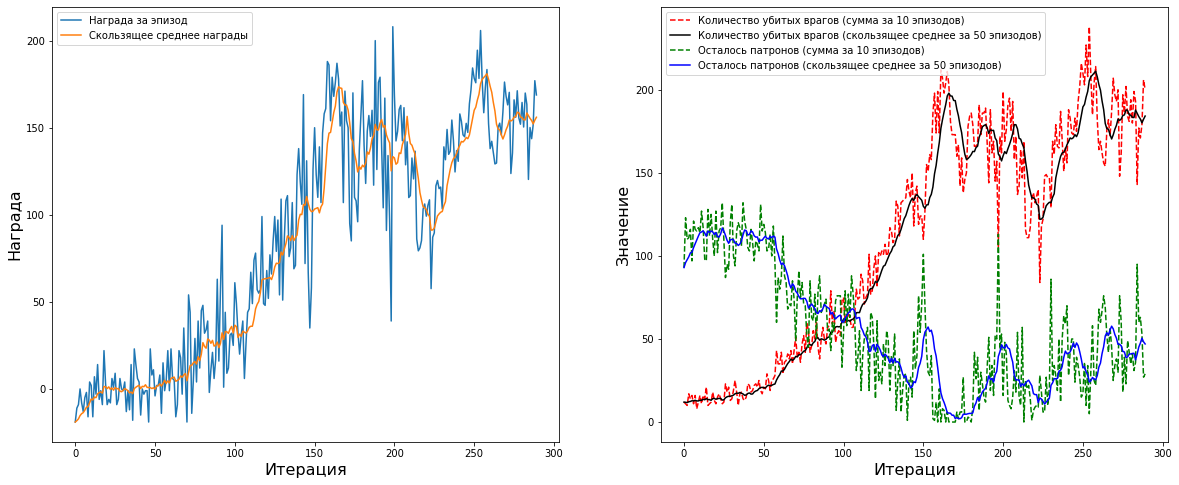

Статистика успешно сохранена.
Закончился 3230-й эпизод. Значение эпсилон: 0, Количество убитых врагов: 18.0, количество оставшихся патронов: 6.0
Закончился 3231-й эпизод. Значение эпсилон: 0, Количество убитых врагов: 24.0, количество оставшихся патронов: 0.0
Закончился 3232-й эпизод. Значение эпсилон: 0, Количество убитых врагов: 23.0, количество оставшихся патронов: 0.0
Закончился 3233-й эпизод. Значение эпсилон: 0, Количество убитых врагов: 24.0, количество оставшихся патронов: 0.0


In [ ]:
#Обучение будет происходить в бесконечном цикле (мы будет прерывать обучение вручную, когда захотим)
game.new_episode()                        #Генерим новый эпизод
game_data = game.get_state()             #Извлекаем первый кадр (это ещё не полноценное состояние)
current_info = game_data.game_variables  #Извлекаем информацию о игре (кол. убитых врагов, патроны, здоровие)
previous_info = current_info              #Записываем информацию о текущем моменте как 'предидущий' момент (чтобы потом могли сравнить разницу)

frame = game_data.screen_buffer                                                      #Извлекаем кадр из игры (480 x 640)
processed_frame = preprocess_frame(frame)                                             #Предобрабатываем кадр в чёрно-белый (размер 64 х 64)
current_state = np.stack([processed_frame.reshape(64, 64)] * num_frames, axis = 2)    #В качестве первого состояния, просто дублируем кадр 4 раза.
previous_state = current_state  #Инициализируем предидущий шаг как текущий шаг

interval_reward = 0  #Инициализируем награду за интервал (10 эпизодов) как 0
interval_kills = 0   #Инициализируем количество убитых врагов (10 эпизодов) как 0
interval_ammos = 0   #Инициализируем количество оставшихся патронов (10 эпизодов) как 0

while True:
  timestep += 1 #Увеличиваем номер шага на 1
  action_index, epsilon = get_action(previous_state, epsilon, action_size)  #Извлекаем индекс награды и новое значение эпсилон
  action_onehot = to_categorical(action_index)                              #Приводим награду в onehot массив
  game.set_action(action_onehot.tolist())                                   #Подаем действие в игровую среду в качестве списка 
  game.advance_action(frames_per_action)                                    #Игра продвигается на 4 кадра (значение frames_per_action)

  game_data = game.get_state()                                    #Предобрабатываем кадр в чёрно-белый (размер 64 х 64 x 1)

  episode_done = game.is_episode_finished() #Проверяем если эпизод закончился

  if episode_done: #Нам необходимо возобновить среду и записать нужные статистики когда заканчивается эпизод
    print(f"Закончился {episode_number}-й эпизод. Значение эпсилон: {round(epsilon, 2)}, Количество убитых врагов: {current_info[0]}, количество оставшихся патронов: {current_info[1]}")
    episode_number += 1   #Увеличиваем номер эпизода на 1
    interval_kills += current_info[0]
    interval_ammos += current_info[1]

    #Чтобы не собирать слишком много данных и чтобы данные было удобно отоброжать на графике, мы записываем результаты лишь раз в 10 эпизодов.
    if episode_number % 10 == 0 and episode_number > 0: #Записываем результат раз в 10 эпизодов
      record_rewards.append(interval_reward)            #Добавляем награду в список всех наград
      record_kills.append(interval_kills)  #Добавляем количество убитых врагов
      record_ammos.append(interval_ammos)  #Добавляем количество неиспользованых патронов
      show_scores(record_rewards, record_kills, record_ammos)  #Записываем результаты в графики
      main_model.save_weights('/content/drive/My Drive/pretrained_networks/vizdoom_DQN_model.h5') #Сохраняем веса модели
      with open('/content/drive/My Drive/pretrained_networks/vizdoom_DQN_stats.txt', 'wb') as f:  #Записываем статистику в файл через библиотеку pickle
        pickle.dump([record_rewards, record_kills, record_ammos, episode_number, timestep, epsilon], f) 
      print("Статистика успешно сохранена.")

      interval_reward, interval_kills, interval_ammos = 0, 0, 0 #Заново инициализируем значения статистики для интервала в 10 эпизодов

    game.new_episode()                       #Затем необходимо начать новый эпизод игры
    game_data = game.get_state()            #Извлекаем новое состояние игры

  current_info = game_data.game_variables  #Извлекаем информацию о игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровие)
  frame = game_data.screen_buffer          #Извлекаем новый кадр из игры
  processed_frame = preprocess_frame(frame) #Предобрабатываем кадр (новая размерность будет 64 х 64 х 1)   
  current_state = np.append(processed_frame, current_state[:, :, :num_frames-1], axis = 2) #Обновляем состояние - удаляем последний кадр и добавляем новый

  environment_reward = game.get_last_reward()                           #Извлекаем нагаду за шаг из среды (логика, которую не можем менять)
  custom_reward = get_reward(previous_info, current_info, episode_done) #Извлекаем нагаду за шаг из самописный функции (самописная награда, значит можем менять логику)
  reward = environment_reward + custom_reward #Общая награда - это сумма награды из среды и самописной награды

  interval_reward += reward #Добавляем награду в переменную для статистики

  add_to_memory(previous_state, action_index, reward, current_state, episode_done) #Добавляем предидущее состояние, действие, награду, и текущее состояние в память
  if timestep % timesteps_per_train == 0 and len(memory) > observation_steps: #Обучаем нашу модель раз в 100 шагов, но только если у нас достаточно данных в памяти
    train_network()
  if timestep % target_model_update_frequency == 0: #Обновляем целевую модель весами основной модели раз в заданное количество (5000) шагов
    update_target_model()

  previous_info = current_info    #Запонимаем предидущию информацию
  previous_state = current_state  #Запоминаем предидущее состояние

Эпсилон достиг своего минимального значение примерно на 1500-м эпизоде.

## Создаем видео с игрой агента

Мы запишем 10 игр и посмотрим на результат. Для записи игр будет использоваться список куда мы будем записывать каждый кадр из игры. Этот массив кадр затем будет обработан и конвертирован в видео.

In [ ]:
video_frames = []  #Кадры из игр будут записываться в этот массив
epsilon = 0   #Устанавливаем эпсилон как 0 (после обучения)

game = DoomGame() #Снова инициализируем среду.
game.load_config("/content/drive/My Drive/databases/ViZDoom/scenarios/defend_the_center.cfg") #Загружаем сценарий "защищай центр"
game.set_screen_resolution(ScreenResolution.RES_640X480) #Устанавливаем размер кадров среды (будет 640 х 480)
game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
game.init() #Снова инициализируем игру

main_model = Make_DQN(state_shape, action_size, learning_rate)   #Создаем основную модель (будет управлять агентом)
main_model.load_weights('/content/drive/My Drive/pretrained_networks/vizdoom_DQN_model.h5')

game.new_episode()                        #Генерим новый эпизод
game_data = game.get_state()             #Извлекаем первый кадр (это ещё не полноценное состояние)

frame = game_data.screen_buffer                                                      #Извлекаем кадр из игры (480 x 640)
processed_frame = preprocess_frame(frame)                                             #Предобрабатываем кадр в чёрно-белый (размер 64 х 64)
current_state = np.stack([processed_frame.reshape(64, 64)] * num_frames, axis = 2)    #В качестве первого состояния, просто дублируем кадр 4 раза.
previous_state = current_state    #Записываем текущее состояние в предидущие состояние

while True:
  action_index, epsilon = get_action(current_state, epsilon, action_size)   #Извлекаем индекс награды и новое значение эпсилон
  action_onehot = to_categorical(action_index)                              #Приводим награду в onehot массив
  game.set_action(action_onehot.tolist())                                   #Подаем действие в игровую среду в качестве списка 
  game.advance_action(frames_per_action)                                    #Игра продвигается на 4 кадра (значение frames_per_action)

  game_data = game.get_state()                                    #Предобрабатываем кадр в чёрно-белый (размер 64 х 64 x 1)

  episode_done = game.is_episode_finished() #Проверяем если эпизод закончился

  if episode_done: #Нам необходимо возобновить среду и записать нужные статистики когда заканчивается эпизод
    game.new_episode()                       #Затем необходимо начать новый эпизод игры
    game_data = game.get_state()            #Извлекаем новое состояние игры
    break #Выходим из игрового цикла

  frame = game_data.screen_buffer          #Извлекаем новый кадр из игры
  video_frames.append(np.rollaxis(frame, 0, 3)) #Добавляем кадр в массив, меняем формат размерности (3, width, height) -> (width, height, 3)

  processed_frame = preprocess_frame(frame) #Предобрабатываем кадр (новая размерность будет 64 х 64 х 1)   
  current_state = np.append(processed_frame, current_state[:, :, :num_frames-1], axis = 2) #Обновляем состояние - удаляем последний кадр и добавляем новый

  previous_state = current_state  #Запоминаем предидущее состояние

##Записываем результат в видео

У нас есть массив кадр, нам нужно конвертировать его в видео. Для этого мы используем библиотеку cv2.

In [ ]:
 #Создаем объект для воспроизведениед видео (задаем путь к файлу видео, формат видео, кадры в секунду, и размер изображений)
out = cv2.VideoWriter('/content/episode.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (640, 480)) #Чем больше кадров в секунду, тем быстее видео будет проигрываться
for i in range(len(video_frames)):   #В цикле добавляем каждый кадр в видео (делаем предобработку кадра - меняем каналы с RGB в BGR - это нужно потому что cv2 воспринимает каналы как BGR)
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))
out.release()   #Закрываем объект для создания видео

## Отображаем видео в колабе

Для этого мы снова обратимся к библиотеки moviepy. Конкретно мы будем использовать функцию VideoFileClip для воспроизведения видео.

In [ ]:
path="/content/episode.avi" #Указываем путь к видео

clip=VideoFileClip(path)    #Извлекаем видео из заданного пути (куда мы ранее записыли видео через cv2)
clip.ipython_display(width=640, maxduration = 40) #Отображаем видео в колабе

Output hidden; open in https://colab.research.google.com to view.

# Дополнительные материалы

[Документация ViZDoom](https://github.com/mwydmuch/ViZDoom)

[Список разных сред для обучения с подкреплением](https://medium.com/@mauriciofadelargerich/reinforcement-learning-environments-cff767bc241f)

[Почему VizDoom хорошая среда для обучения (видео)](https://www.youtube.com/watch?v=oMHTXz0lYbA&ab_channel=RL%D0%A1ommunity)

## Ультра-про Задание

[Vizdoom Deathmatch](https://www.youtube.com/watch?v=947bSUtuSQ0&ab_channel=IntelISL)